## 1. Importing Libraries

In [2]:
import pandas as pd

import numpy as np

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.datetime import DatetimeFeatures

# import the algorithms:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Learning Curvs : 
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

from xgboost import XGBRegressor

import joblib

import matplotlib.pyplot as plt

## 2. Display Settings

In [4]:
pd.set_option("display.max_columns",None)

In [5]:
sklearn.set_config(transform_output="pandas")

## 3. Getting the Data

In [7]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")


In [8]:
train_df.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187


### 3.1 Split the data

In [10]:
def split_data(data):
    X = data.drop(columns='price')
    y = data.price.copy()
    return (X,y)

In [11]:
X_train,y_train = split_data(train_df)

In [12]:
y_train

0       4995
1       8372
2       6117
3       7770
4       9187
       ...  
635     4282
636    13067
637     4423
638     7670
639    10844
Name: price, Length: 640, dtype: int64

In [13]:
X_val,y_val = split_data(val_df)
X_val.shape, y_val.shape

((160, 9), (160,))

In [14]:
X_test,y_test = split_data(test_df)
X_test.shape, y_test.shape

((200, 9), (200,))

### 3.2 Meta-info

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


## 4. Data Preprocessing

In [18]:
num_cols = ["duration","total_stops"]

dt_cols = ["date_of_journey","dep_time","arrival_time"]

cat_cols = [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [19]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [20]:
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=['month','week','day_of_week','day_of_month'], format='mixed')),
    ("scaler", StandardScaler())
])

time_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=['hour','minute'], format='mixed')),
    ("scaler", StandardScaler())
])

In [21]:
preprocessor = ColumnTransformer(transformers=[
    ("numeric", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols),
    ("doj", doj_transformer, ['date_of_journey']),
    ("time", time_transformer, ['dep_time','arrival_time'])
])

In [22]:
preprocessor.fit_transform(X_train)

,numeric__duration,numeric__total_stops,cat__airline_Air Asia,cat__airline_Air India,cat__airline_Goair,cat__airline_Indigo,cat__airline_Jet Airways,cat__airline_Multiple Carriers,cat__airline_Spicejet,cat__airline_Vistara,cat__source_Banglore,cat__source_Chennai,cat__source_Delhi,cat__source_Kolkata,cat__source_Mumbai,cat__destination_Banglore,cat__destination_Cochin,cat__destination_Delhi,cat__destination_Hyderabad,cat__destination_Kolkata,cat__destination_New Delhi,cat__additional_info_1 Long layover,cat__additional_info_In-flight meal not included,cat__additional_info_No Info,cat__additional_info_No check-in baggage included,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute
0,-1.095918,-1.212132,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.151587,1.331443,0.566118,0.963554,-0.462055,-0.140057,-0.345231,1.493859
1,1.435699,0.317975,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,1.050498,0.604465,-0.640951,-1.229863,-0.935607,0.891041
2,1.824412,1.848082,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,1.140212,-0.402640,-0.113711,-0.640951,-0.684960,-0.345231,-1.218823
3,1.904148,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.772093,-1.371399,-1.430369,1.326906,-0.140057,1.278301,1.795268
4,0.847647,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,0.948982,0.081739,-0.831888,0.790218,-1.229863,-0.492825,1.192450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,-0.936446,-1.212132,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.580863,0.566118,-0.113711,-1.535432,1.767103,-0.935607,1.192450
636,0.100122,0.317975,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.184059,0.081739,-0.472800,-0.640951,0.677297,1.130707,-1.218823
637,-0.946413,-1.212132,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,-0.402640,0.245377,-1.177640,-0.957412,-0.788013,1.493859
638,0.189825,0.317975,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,-0.402640,0.245377,-0.819847,1.222200,1.130707,-1.520232


## 5. Model Selection

In [24]:
algorithms = {
    "Linear Regression" : LinearRegression(),
    "Support Vector Machine" : SVR(),
    "Random Forest" : RandomForestRegressor(n_estimators=10),
    "XG Boost" : XGBRegressor(n_estimators=10)
}

In [25]:
data = pd.concat([train_df,val_df],ignore_index=True,axis=0)
data

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
795,Spicejet,2019-04-03,Delhi,Cochin,08:45:00,13:15:00,270,1.0,No check-in baggage included,4098
796,Spicejet,2019-03-01,Mumbai,Hyderabad,05:45:00,07:05:00,80,0.0,No Info,12475
797,Multiple Carriers,2019-05-18,Delhi,Cochin,03:50:00,12:35:00,525,1.0,No Info,10197
798,Jet Airways,2019-03-01,Banglore,New Delhi,22:50:00,00:45:00,1555,1.0,No Info,26890


In [26]:
X_data,y_data = split_data(data)
X_data

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info
...,...,...,...,...,...,...,...,...,...
795,Spicejet,2019-04-03,Delhi,Cochin,08:45:00,13:15:00,270,1.0,No check-in baggage included
796,Spicejet,2019-03-01,Mumbai,Hyderabad,05:45:00,07:05:00,80,0.0,No Info
797,Multiple Carriers,2019-05-18,Delhi,Cochin,03:50:00,12:35:00,525,1.0,No Info
798,Jet Airways,2019-03-01,Banglore,New Delhi,22:50:00,00:45:00,1555,1.0,No Info


In [27]:
def plot_curves(sizes,mean_scores, std_scores, label, ax):
    ax.plot(
        sizes,
        mean_scores,
        marker = "o",
        label=label
    )

    ax.fill_between(
        x=sizes,
        y1=mean_scores - std_scores,
        y2=mean_scores + std_scores,
        alpha=0.5
    )

In [28]:
def transform(X_data,processor):
    return processor.fit_transform(X_data)

In [29]:
def plot_learning_curves(name,algorithm, figsize=(12,6)):
    model = Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", algorithm)
    ])

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X_data,
        y=y_data,
        cv=5,
        scoring="r2",
        n_jobs=-1,
        random_state=42
    )

    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"


    fig, ax = plt.subplots(figsize=figsize)

    # Training curve
    ax.plot(
        train_sizes,
        mean_train_scores,
        marker="o",
        label=f"Train ({train_score})",
    )
    ax.fill_between(
        x=train_sizes,
        y1=mean_train_scores - std_train_scores,
        y2=mean_train_scores + std_train_scores,
        alpha=0.5
    )
    # Test curve
    ax.plot(
        train_sizes,
        mean_test_scores,
        marker="o",
        label=f"Test ({test_score})",
    )
    ax.fill_between(
        x=train_sizes,
        y1=mean_test_scores - std_test_scores,
        y2=mean_test_scores + std_test_scores,
        alpha=0.5
    )

    ax.set(xlabel="Training Set Size", ylabel="R-square",title=name)

    ax.legend()

    plt.show()

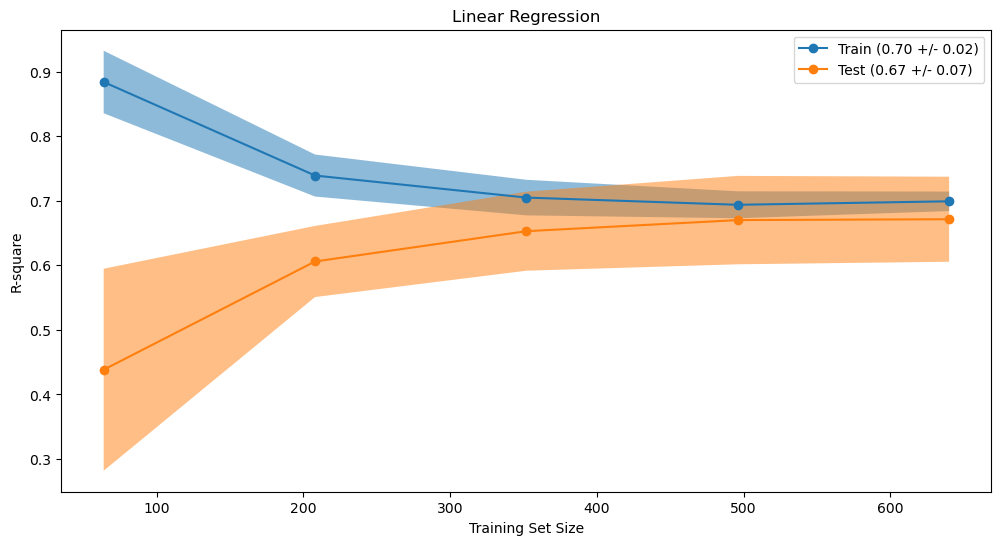

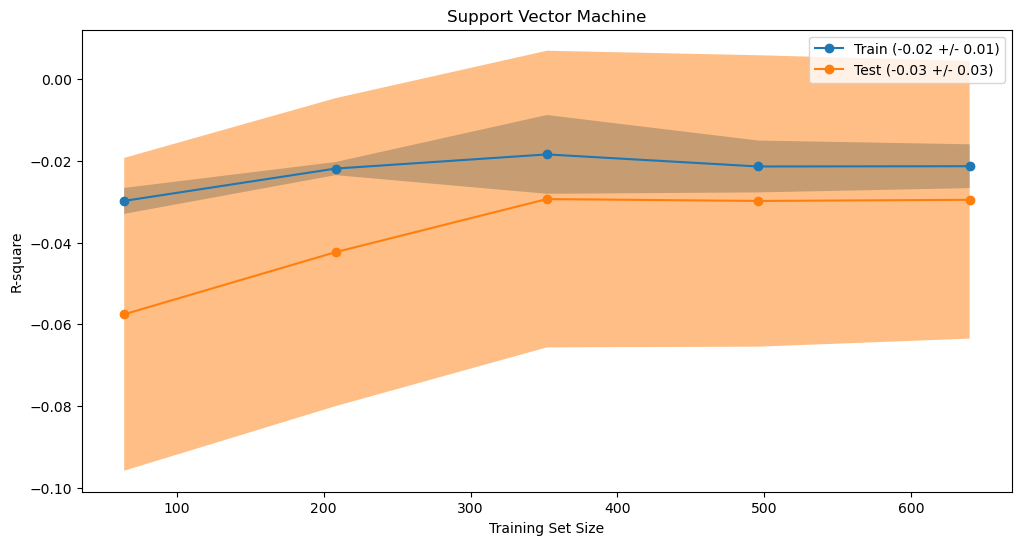

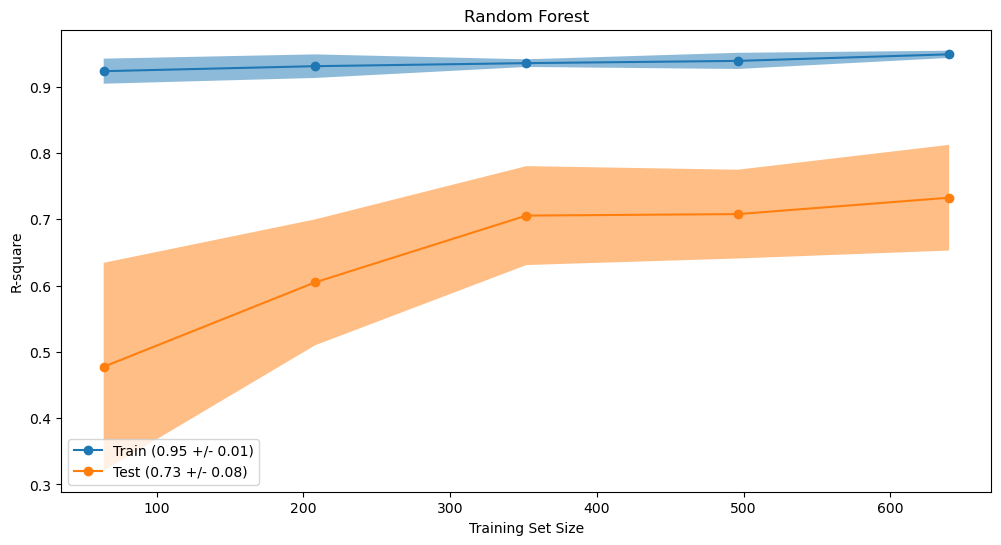

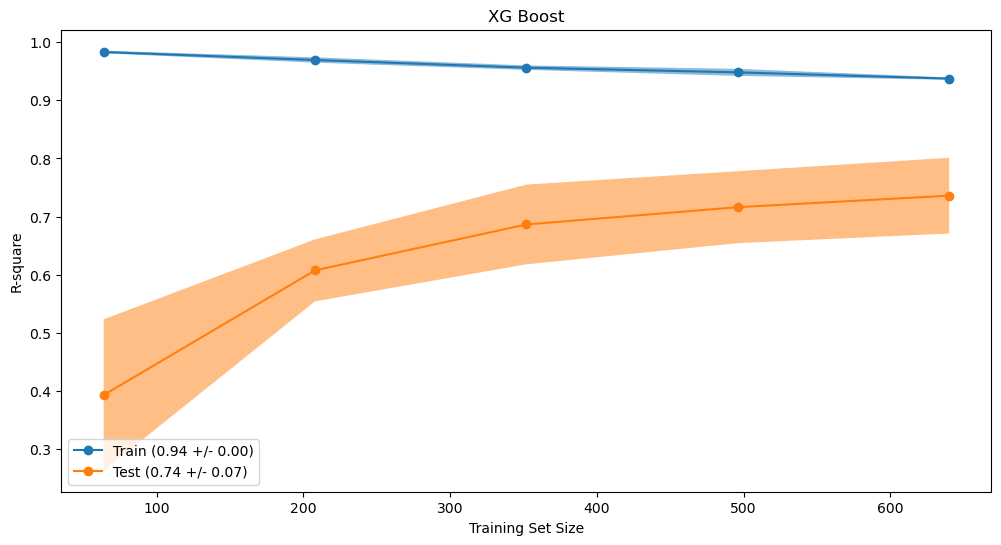

In [30]:
for name, alg in algorithms.items():
    plot_learning_curves(name,alg)

## 6. Model Training

In [32]:
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("rf", RandomForestRegressor(n_estimators=100,oob_score=True,verbose=2,n_jobs=-1))
])

In [33]:
model.fit(X_data,y_data)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'sourc...
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf',
                 RandomForestRegressor(n_jobs=-1, oob_score=True, verbose=2))])

## 7. Model Evaluation

In [35]:
def evaluate_model(model,X,y):
    y_pred = model.predict(X)
    return r2_score(y,y_pred)

In [36]:
print(f"R2 score on Training Data is = {evaluate_model(model,X_data,y_data)}")

R2 score on Training Data is = 0.9647818803817174


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [37]:
print(f"R2 score on Training Data is = {evaluate_model(model,X_test,y_test)}")

R2 score on Training Data is = 0.7071154042066777


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


## 8. Model Persistence

In [39]:
joblib.dump(model,"model.joblib")

['model.joblib']

In [40]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'sourc...
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf',
                 RandomForestRegressor(n_jobs=-1, oob_score=True, verbose=2))])

In [41]:
y_pred = saved_model.predict(X_test)

r2_score(y_test,y_pred)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.7071154042066777